<a href="https://colab.research.google.com/github/AlesKas/neural_networks/blob/main/CIFAR_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install torch torchvision matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
! pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import torch
import random

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
BATCH_SIZE = 100
NUM_CLASSES = 10
INPUT_SIZE = 32 * 32
DATASET = CIFAR10(root='data/', download=True, train=True, transform=transforms.ToTensor())

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [46]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        accu = accuracy(out,labels)
        return loss,accu
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.cuda(), labels.cuda()
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'Loss': loss.detach(), 'Accuracy': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch :",epoch + 1)
        print(f'Train Accuracy:{result["train_accuracy"]*100:.2f}% Validation Accuracy:{result["Accuracy"]*100:.2f}%')
        print(f'Train Loss:{result["train_loss"]:.4f} Validation Loss:{result["Loss"]:.4f}')

In [47]:
class CIFAR10CNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

    def _init_weights(self, module):
          if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()

In [42]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader,epochs=10,learning_rate=0.001):
    best_valid = None
    history = []
    optimizer = torch.optim.Adam(model.parameters(), learning_rate,weight_decay=0.0005)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in tqdm(train_loader):
            loss,accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        if(best_valid == None or best_valid<result['Accuracy']):
            best_valid=result['Accuracy']
            torch.save(model.state_dict(), 'cifar10-cnn.pth')
        history.append(result)
    return history

def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)

    idxs = np.random.permutation(n)

    return idxs[n_val:], idxs[:n_val]

train_indexes, validation_indexes = split_indices(len(DATASET), 0.2)

train_sampler = SubsetRandomSampler(train_indexes)
train_loader = DataLoader(DATASET, BATCH_SIZE, sampler=train_sampler)

val_sampler = SubsetRandomSampler(validation_indexes)
val_loader = DataLoader(DATASET, BATCH_SIZE, sampler=val_sampler)

In [43]:
def plot_accuracies(history):
    Validation_accuracies = [x['Accuracy'] for x in history]
    Training_Accuracies = [x['train_accuracy'] for x in history]
    plt.plot(Training_Accuracies, '-rx')
    plt.plot(Validation_accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['Loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [44]:
%matplotlib inline

100%|██████████| 400/400 [00:10<00:00, 39.95it/s]


Epoch : 1
Train Accuracy:55.26% Validation Accuracy:61.15%
Train Loss:1.2368 Validation Loss:1.0792


100%|██████████| 400/400 [00:10<00:00, 39.91it/s]


Epoch : 2
Train Accuracy:72.48% Validation Accuracy:74.77%
Train Loss:0.7813 Validation Loss:0.7326


100%|██████████| 400/400 [00:10<00:00, 36.48it/s]


Epoch : 3
Train Accuracy:78.65% Validation Accuracy:75.42%
Train Loss:0.6144 Validation Loss:0.6977


100%|██████████| 400/400 [00:10<00:00, 39.12it/s]


Epoch : 4
Train Accuracy:82.55% Validation Accuracy:78.21%
Train Loss:0.4987 Validation Loss:0.6370


100%|██████████| 400/400 [00:10<00:00, 38.49it/s]


Epoch : 5
Train Accuracy:85.89% Validation Accuracy:77.38%
Train Loss:0.4037 Validation Loss:0.6785


100%|██████████| 400/400 [00:10<00:00, 37.52it/s]


Epoch : 6
Train Accuracy:87.84% Validation Accuracy:78.50%
Train Loss:0.3441 Validation Loss:0.6676


100%|██████████| 400/400 [00:10<00:00, 37.92it/s]


Epoch : 7
Train Accuracy:90.22% Validation Accuracy:80.01%
Train Loss:0.2799 Validation Loss:0.6124


100%|██████████| 400/400 [00:10<00:00, 38.25it/s]


Epoch : 8
Train Accuracy:91.10% Validation Accuracy:80.94%
Train Loss:0.2503 Validation Loss:0.6319


100%|██████████| 400/400 [00:10<00:00, 38.24it/s]


Epoch : 9
Train Accuracy:92.98% Validation Accuracy:79.25%
Train Loss:0.2060 Validation Loss:0.7499


100%|██████████| 400/400 [00:10<00:00, 38.61it/s]


Epoch : 10
Train Accuracy:93.56% Validation Accuracy:80.68%
Train Loss:0.1837 Validation Loss:0.6531


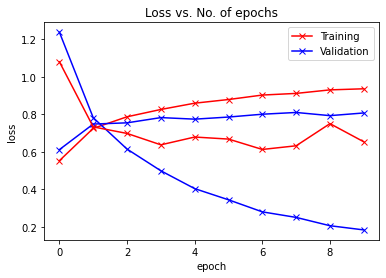

In [48]:
model = CIFAR10CNN().to(dev)

history = fit(model, train_loader, val_loader)
plot_accuracies(history)
plot_losses(history)